In [11]:
import numpy as np
import pandas as pd
import os
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.svm import LinearSVR, SVR, SVC,LinearSVC
from sklearn.datasets import make_regression
from sklearn.preprocessing import normalize 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
# Read in data
df_training_original = pd.read_csv('train_features.csv')
df_training_label = pd.read_csv('train_labels.csv')
all_pids = [pid for pid in df_training_original['pid'].unique()]

In [3]:
def getPatientData(trainingData, pids, patients=0, mode='pid'):
    if mode == 'number':
        pids = all_pids[:patients]
    if len(pids) == 0:
        return trainingData
    #pids = np.array(pids).astype(np.float)
    patients = [trainingData.iloc[idx] for idx in range(0, len(trainingData)) if trainingData['pid'][idx] in pids]    
    #patientTrainingDataIndex = [trainingData.iloc[idx] for idx, col in enumerate(trainingData) if trainingData['pid'][idx] in pids]    
    return pd.DataFrame(patients)

def partitionData(trainingDataPids, trainingPartition=80):
    validationPartition = 100 - trainingPartition
    countTraining = int((trainingPartition/100)*len(trainingDataPids))
    training = trainingDataPids[:countTraining]
    validation = trainingDataPids[countTraining:]
    print('')
    print('Training size: ' + str(countTraining))
    print('Validation size: ' + str(len(validation)))
    return training, validation

def populateData(X,Y):
    Z = pd.merge(X, Y, on='pid')
    YData = Z[Y.columns].iloc[:,1:]
    XData = Z[X.columns].iloc[:,1:]
    return XData, YData

In [4]:
df_training = df_training_original.copy()

# See how many values are missing in which rows
loss = df_training_original.isnull().any()
lossRow = df_training[df_training_original == loss].sum()
print('Number of missing values in data:')
print(lossRow[lossRow > 0].sort_values(ascending=False))

# Filter out certain rows with a lot of missing data
lossColumns = list(lossRow[lossRow > 100].index)
df_training = df_training.drop(columns=lossColumns)

# Set all time data to be between 1-12
X_ALL = pd.DataFrame(columns = df_training.columns)
if os.path.exists('x_time_adjusted.csv'):
    X_ALL = pd.read_csv('x_time_adjusted.csv', index_col=False)
    X_ALL = X_ALL.iloc[:,1:]
else:
    for pids in all_pids:
        df_trainingTemp = df_training[df_training['pid'] == pids]
        df_trainingTemp['Time'] = df_trainingTemp['Time'] - (df_trainingTemp['Time'].min() -1)
        X_ALL = pd.concat([X_ALL, df_trainingTemp])
    
df_training = X_ALL.copy()
# Partition data in training and validation
trainingPIDS, validationPIDS = partitionData(all_pids)


Number of missing values in data:
FiO2                3246.0
BaseExcess          1267.0
Creatinine           837.0
Lactate              295.0
Bilirubin_total      219.0
RRate                101.0
Magnesium             59.0
Phosphate             59.0
Bilirubin_direct      19.0
Calcium               19.0
TroponinI             11.0
BUN                    9.0
WBC                    8.0
dtype: float64

Training size: 15196
Validation size: 3799


In [5]:
## Divide data in half

X_pid_train = pd.DataFrame(columns=['pid','Age', 'Temp1','Temp2','Temp3','Temp4','Temp5','Temp6',
                              'HR1','HR2','HR3','HR4','HR5','HR6',
                              'Abps1','Abps2','Abps3','Abps4','Abps5','Abps6',
                              'ABPm1','ABPm2','ABPm3','ABPm4','ABPm5','ABPm6',
                                    'SpO21','SpO22','SpO23','SpO24','SpO25','SpO26',
                                    'ABPd1','ABPd2','ABPd3','ABPd4','ABPd5','ABPd6'
                                   ])

Y_pid_train = pd.DataFrame(columns = df_training_label.columns)
for pid in all_pids:
    uniqueData = df_training_original[df_training_original['pid']==pid]
    yResult = df_training_label[df_training_label['pid'] == pid]
    yResult['pid'] = yResult['pid'].astype(np.float)
    Temp = uniqueData['Temp']
    #if Temp.isna().sum() > 3:
    #    continue
    HR = uniqueData['Heartrate']
    Abps = uniqueData['ABPs']
    Abpm = uniqueData['ABPm']
    Abpd = uniqueData['ABPd']
    
    spo2 = uniqueData['SpO2']
    pH  = uniqueData['pH']
    DF = pd.DataFrame([[np.nan,np.nan, np.nan, np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,
                        np.nan,np.nan, np.nan, np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,
                        np.nan,np.nan, np.nan, np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,
                        np.nan,np.nan, np.nan, np.nan,np.nan,np.nan,np.nan,np.nan]],
                      columns=['pid','Age', 'Temp1','Temp2','Temp3','Temp4','Temp5','Temp6',
                              'HR1','HR2','HR3','HR4','HR5','HR6',
                              'Abps1','Abps2','Abps3','Abps4','Abps5','Abps6',
                              'ABPm1','ABPm2','ABPm3','ABPm4','ABPm5','ABPm6',
                                    'SpO21','SpO22','SpO23','SpO24','SpO25','SpO26',
                                    'ABPd1','ABPd2','ABPd3','ABPd4','ABPd5','ABPd6'
                                   ])

    DF['pid'] = uniqueData['pid'].iloc[0]
    DF['Age'] = uniqueData['Age'].iloc[0]
    for i in range(0,6):
        DF['Temp' + str(i+1)] = Temp.iloc[2*i]
        DF['HR' + str(i+1)] = HR.iloc[2*i]
        DF['Abps' + str(i+1)] = Abps.iloc[2*i]
        DF['ABPm' + str(i+1)] = Abpm.iloc[2*i]
        DF['SpO2' + str(i+1)] = spo2.iloc[2*i]
        DF['ABPd' + str(i+1)] = Abpd.iloc[2*i]

#        DF['pH' + str(i+1)] = pH.iloc[2*i]

    X_pid_train = pd.concat([X_pid_train, DF])
    Y_pid_train = pd.concat([Y_pid_train, yResult])
print(X_pid_train.shape)


C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


(18995, 38)


In [361]:
# Only take every third datapoint

X_pid_train = pd.DataFrame(columns=['pid','Age', 
                                    'Temp1','Temp2','Temp3',
                              'HR1','HR2','HR3',
                              'Abps1','Abps2','Abps3',
                              'ABPm1','ABPm2','ABPm3',
                                    'SpO21','SpO22','SpO23',
                                    'ABPd1','ABPd2','ABPd3'
                                   ])

Y_pid_train = pd.DataFrame(columns = df_training_label.columns)
for pid in all_pids[:100000]:
    uniqueData = df_training_original[df_training_original['pid']==pid]
    yResult = df_training_label[df_training_label['pid'] == pid]
    yResult['pid'] = yResult['pid'].astype(np.float)
    Temp = uniqueData['Temp']
    #if Temp.isna().sum() > 3:
    #    continue
    HR = uniqueData['Heartrate']
    Abps = uniqueData['ABPs']
    Abpm = uniqueData['ABPm']
    Abpd = uniqueData['ABPd']
    spo2 = uniqueData['SpO2']
    #pH  = uniqueData['pH']
    
    DF = pd.DataFrame([[np.nan, np.nan, np.nan, np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,
                        np.nan,np.nan, np.nan, np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]],
                      columns=['pid','Age', 
                              'Temp1','Temp2','Temp3',
                              'HR1','HR2','HR3',
                              'Abps1','Abps2','Abps3',
                              'ABPm1','ABPm2','ABPm3',
                              'SpO21','SpO22','SpO23',
                              'ABPd1','ABPd2','ABPd3'])

    DF['pid'] = uniqueData['pid'].iloc[0]
    DF['Age'] = uniqueData['Age'].iloc[0]
    for i, j in enumerate([0,5,11]):
        DF['Temp' + str(i+1)] = Temp.iloc[j]
        DF['HR' + str(i+1)] = HR.iloc[j]
        DF['Abps' + str(i+1)] = Abps.iloc[j]
        DF['ABPm' + str(i+1)] = Abpm.iloc[j]
        DF['SpO2' + str(i+1)] = spo2.iloc[j]
        DF['ABPd' + str(i+1)] = Abpd.iloc[j]

#        DF['pH' + str(i+1)] = pH.iloc[2*i]
    X_pid_train = pd.concat([X_pid_train, DF])
    Y_pid_train = pd.concat([Y_pid_train, yResult])
print(X_pid_train.shape)

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


(18995, 20)


In [153]:
# Only take every third datapoint
def lastValue(df):
    length = len(df)
    for indexDF in range(1, length):
        if np.isnan(np.float64(df.iloc[-indexDF])) == False:
            return df.iloc[-indexDF]
        else:
            continue
    
X_pid_train = pd.DataFrame(columns=['pid','Age', 
                                    'Temp','HR','Abps','ABPm','SpO2','ABPd'
                                   ])

Y_pid_train = pd.DataFrame(columns = df_training_label.columns)
for pid in all_pids[:100000]:
    uniqueData = df_training_original[df_training_original['pid']==pid]
    yResult = df_training_label[df_training_label['pid'] == pid]
    yResult['pid'] = yResult['pid'].astype(np.float)
    Temp = uniqueData['Temp']
    #if Temp.isna().sum() > 3:
    #    continue
    HR = uniqueData['Heartrate']
    Abps = uniqueData['ABPs']
    Abpm = uniqueData['ABPm']
    Abpd = uniqueData['ABPd']
    spo2 = uniqueData['SpO2']
    #pH  = uniqueData['pH']
   
    
    DF = pd.DataFrame([[np.nan, np.nan, np.nan, np.nan,np.nan,np.nan,np.nan,np.nan]],
                      columns=['pid','Age','Temp','HR','Abps','ABPm','SpO2','ABPd'])

    DF['pid'] = uniqueData['pid'].iloc[0]
    DF['Age'] = uniqueData['Age'].iloc[0]
    for i, j in enumerate([11]):
        DF['Temp'] = lastValue(Temp)
        DF['HR'] = lastValue(HR)
        DF['Abps'] = lastValue(Abps)
        DF['ABPm'] = lastValue(Abpm)
        DF['SpO2'] = lastValue(spo2)
        DF['ABPd'] = lastValue(Abpd)
#        DF['pH' + str(i+1)] = pH.iloc[2*i]
    X_pid_train = pd.concat([X_pid_train, DF])
    Y_pid_train = pd.concat([Y_pid_train, yResult])
print(X_pid_train.shape)

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(18995, 8)


In [154]:
print(X_pid_train.head())

     pid   Age  Temp     HR   Abps   ABPm   SpO2  ABPd
0      1  34.0  38.0   69.0  102.0   53.0  100.0  39.0
0     10  71.0  36.0   75.0  136.0  102.0   98.0  78.0
0    100  68.0  38.0  113.0  116.0   84.0   97.0  67.0
0   1000  79.0  38.0   79.0  125.0   71.0   95.0  55.0
0  10000  76.0  37.0   90.0  132.0   67.0   99.0  44.0


In [155]:
my_imputer = SimpleImputer(strategy='mean')
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_pid_train))
imputed_X_train_plus.columns = X_pid_train.columns
print(imputed_X_train_plus)

           pid   Age  Temp     HR   Abps   ABPm   SpO2       ABPd
0          1.0  34.0  38.0   69.0  102.0   53.0  100.0  39.000000
1         10.0  71.0  36.0   75.0  136.0  102.0   98.0  78.000000
2        100.0  68.0  38.0  113.0  116.0   84.0   97.0  67.000000
3       1000.0  79.0  38.0   79.0  125.0   71.0   95.0  55.000000
4      10000.0  76.0  37.0   90.0  132.0   67.0   99.0  44.000000
...        ...   ...   ...    ...    ...    ...    ...        ...
18990   9993.0  80.0  35.0  112.0  101.0   76.0  100.0  68.000000
18991   9995.0  73.0  36.0   64.0  174.0  123.0   96.0  63.239688
18992   9996.0  53.0  38.0   95.0   95.0   68.0  100.0  50.500000
18993   9998.0  89.0  37.0  100.0  156.0   95.0  100.0  59.000000
18994   9999.0  85.0  36.0   79.0  128.0   85.0   98.0  89.000000

[18995 rows x 8 columns]


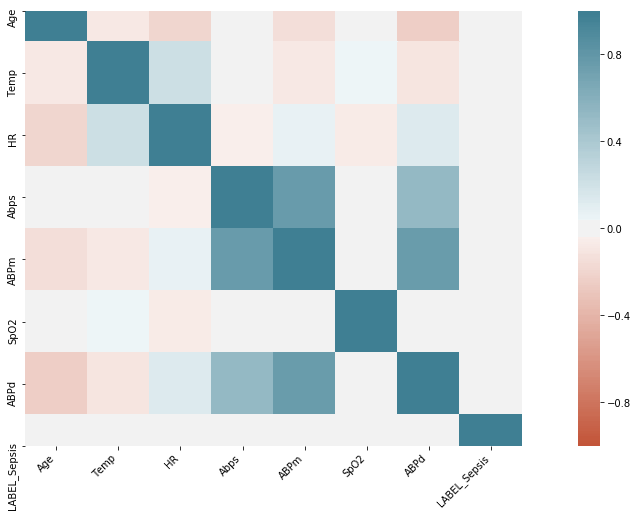

In [186]:
y2 = y_pid_fit[['pid','LABEL_Sepsis']]
gg3 = pd.merge(X_norm, y2 )

plt.figure(figsize=(20,8))
corr = gg3[gg3.columns[1:31]].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [156]:

#regr = LinearSVC(C=1, fit_intercept=False, multi_class='cramer_singer')

# Drop rows that contain 0 for all y targets (get rid of a lot of negatives)
cols = df_training_label.columns
indices = [df_training_label.iloc[x,:].name for x in range(0, len(df_training_label)) if not(df_training_label.iloc[x,1:12] == [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]).all()]
df_training2 = df_training_label.loc[indices,:]
X_filtered = imputed_X_train_plus.copy()
X_norm = X_filtered.copy()
X_norm = X_norm[X_norm['pid'].isin(list(df_training2['pid']))]
y_pid_fit = Y_pid_train[Y_pid_train['pid'].isin(list(df_training2['pid']))]
y_pid_fit = y_pid_fit.reset_index(drop=True)

# Normalize the data
X_norm.iloc[:,1:] = StandardScaler().fit_transform(X_norm.iloc[:,1:])
X_norm = pd.DataFrame(X_norm)
X_norm = X_norm.reset_index(drop=True)
X_norm.columns = X_filtered.columns
print(X_norm.shape)



# Train MLPClassifier
#regr =   KNeighborsClassifier(3)
regr = MLPClassifier(alpha=1e-5,hidden_layer_sizes=(150,150), random_state=1, solver='sgd', max_iter=200)
#regr = RidgeClassifierCV()
#regr = RandomForestClassifier()
regr.fit(np.array(X_norm.iloc[:11000,1:]), np.array(y_pid_fit.iloc[:11000,11]))


(11129, 8)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(150, 150), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [158]:
f = regr.predict_proba(X_norm.iloc[11000:,1:])
f = pd.DataFrame(f[:,1])
f['pid'] = X_norm.iloc[11000:,0].reset_index(drop=True)
f.columns = ['LABEL_Sepsis', 'pid']
#print(f)
#f['LABEL_Sepsis'] = np.nan
#f['LABEL_RRate'] = np.nan
#f['LABEL_ABPm'] = np.nan
#f['LABEL_SpO2'] = np.nan
#f['LABEL_Heartrate'] = np.nan
#f = f[Y_pid_train.columns]
get_score(y_pid_fit.iloc[11000:,:], f)

0.4430309734513274

In [ ]:
#mit daten in 3 geteilt 0.6663326701565544 (50,50)
# mit 6 datenpunkten 0.5481194690265486 mit netz (100,100) 0.599004424778761 (150,150)

In [42]:
import sklearn.metrics as metrics

TESTS = ['LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST', 'LABEL_Alkalinephos', 'LABEL_Bilirubin_total',
         'LABEL_Lactate', 'LABEL_TroponinI', 'LABEL_SaO2',
         'LABEL_Bilirubin_direct', 'LABEL_EtCO2']
def get_score(df_true, df_submission):
    df_submission = df_submission.sort_values('pid')
    df_true = df_true.sort_values('pid')
    
    #task1 = np.mean([metrics.roc_auc_score(df_true[entry], df_submission[entry]) for entry in TESTS])
    task2 = metrics.roc_auc_score(df_true['LABEL_Sepsis'], df_submission['LABEL_Sepsis'])
    #task3 = np.mean([0.5 + 0.5 * np.maximum(0, metrics.r2_score(df_true[entry], df_submission[entry])) for entry in VITALS])
    #score = np.mean([task1, task2, task3])
    return task2

In [185]:

gg = X_norm.copy()
y2 = y_pid_fit[['pid','LABEL_Sepsis']]
gg3 = pd.merge(X_norm, y2 )
print(gg3)

           pid  LABEL_Sepsis
0          1.0           0.0
1        100.0           0.0
2       1000.0           0.0
3      10007.0           1.0
4      10009.0           0.0
...        ...           ...
11124    999.0           1.0
11125   9993.0           0.0
11126   9996.0           0.0
11127   9998.0           0.0
11128   9999.0           0.0

[11129 rows x 2 columns]
           pid       Age      Temp        HR      Abps      ABPm      SpO2  \
0          1.0 -1.769359  1.279899 -0.916134 -0.831303 -1.716414  0.829499   
1        100.0  0.342271  1.279899  1.573689 -0.213021  0.175566 -0.131410   
2       1000.0  1.025445  1.279899 -0.350265  0.184446 -0.617845 -0.772016   
3      10007.0 -0.154583  1.279899 -1.482003 -0.213021  0.663819 -0.131410   
4      10009.0  0.404378  0.078588  0.838059 -0.477999 -1.838477  0.188893   
...        ...       ...       ...       ...       ...       ...       ...   
11124    999.0  0.777018 -1.122722 -0.689787  0.047366 -2.143635  0.829499   
11